# MNIST CNN

In [1]:
import tensorflow as tf    
import keras
from keras.utils import to_categorical
from keras import layers, models, callbacks
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

SEED = 1
np.random.seed(SEED)
sns.set(style="white", context="notebook", palette="deep")

### Loading Data

In [2]:
train = pd.read_csv("../input/digit-recognizer/train.csv")
test = pd.read_csv("../input/digit-recognizer/test.csv")

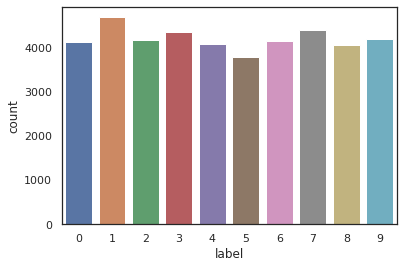

In [3]:
y_train = train["label"]
X_train = train.drop(labels=["label"], axis=1)

sns.countplot(y_train)

### Null check

In [4]:
print(X_train.isnull().any().any(), y_train.isnull().any().any(), test.isnull().any().any())

False False False


### Normalization

In [5]:
X_train /= 255

In [6]:
test /= 255

### Reshape

In [7]:
X_train = X_train.to_numpy().reshape(-1, 28, 28, 1)
test = test.to_numpy().reshape(-1, 28, 28, 1)

In [8]:
print(X_train.shape, test.shape)

(42000, 28, 28, 1) (28000, 28, 28, 1)


### To One-Hot

In [9]:
y_train = to_categorical(y_train)

### Validation data

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=SEED, train_size=0.9)

In [11]:
print(X_train.shape, X_valid.shape)

(37800, 28, 28, 1) (4200, 28, 28, 1)


### Previewing

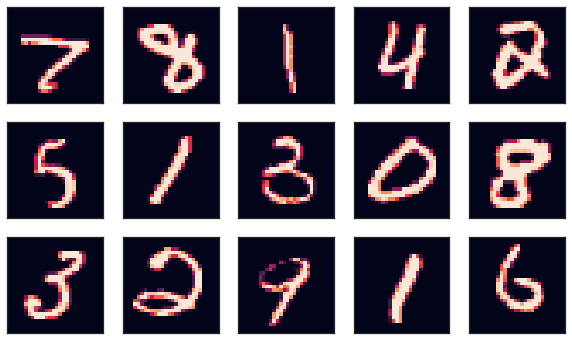

In [12]:
plt.figure(figsize=(10, 6))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.imshow(X_train[i,:,:,0])
    plt.xticks([])
    plt.yticks([])

### CNN

In [13]:
model = models.Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(5, 5), activation="relu", padding="same", input_shape=(28, 28, 1)))
model.add(layers.Conv2D(filters=32, kernel_size=(5, 5), activation="relu", padding="same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(filters=64, kernel_size=(5, 5), activation="relu", padding="same"))
model.add(layers.Conv2D(filters=64, kernel_size=(5, 5), activation="relu", padding="same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation="softmax"))

### Compiling

In [14]:
model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["acc"])

In [15]:
learning_rate_reduction = callbacks.ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

In [16]:
# model_checkpoints = callbacks.ModelCheckpoint("./checkpoints/weights{epoch:03d}.h5", save_weights_only=True)

In [17]:
epochs = 20
batch_size = 86

### Augmentation

In [18]:
datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1)

### Training

In [19]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), 
                             epochs=epochs,
                             validation_data=(X_valid, y_valid),
                             steps_per_epoch=len(X_train) // batch_size,
                             callbacks=[learning_rate_reduction])

Epoch 1/20
439/439 [==============================] - 16s 37ms/step - loss: 0.3963 - acc: 0.8723 - val_loss: 0.0590 - val_acc: 0.9783 - lr: 0.0010
Epoch 2/20
439/439 [==============================] - 15s 33ms/step - loss: 0.0983 - acc: 0.9713 - val_loss: 0.0338 - val_acc: 0.9888 - lr: 0.0010
Epoch 3/20
439/439 [==============================] - 15s 33ms/step - loss: 0.0747 - acc: 0.9784 - val_loss: 0.0270 - val_acc: 0.9914 - lr: 0.0010
Epoch 4/20
439/439 [==============================] - 15s 34ms/step - loss: 0.0633 - acc: 0.9811 - val_loss: 0.0365 - val_acc: 0.9881 - lr: 0.0010
Epoch 5/20
439/439 [==============================] - 16s 36ms/step - loss: 0.0580 - acc: 0.9835 - val_loss: 0.0301 - val_acc: 0.9910 - lr: 0.0010
Epoch 6/20
438/439 [============================>.] - ETA: 0s - loss: 0.0555 - acc: 0.9850
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
439/439 [==============================] - 15s 34ms/step - loss: 0.0555 - acc: 0.9849 - val_lo

### Evaluating

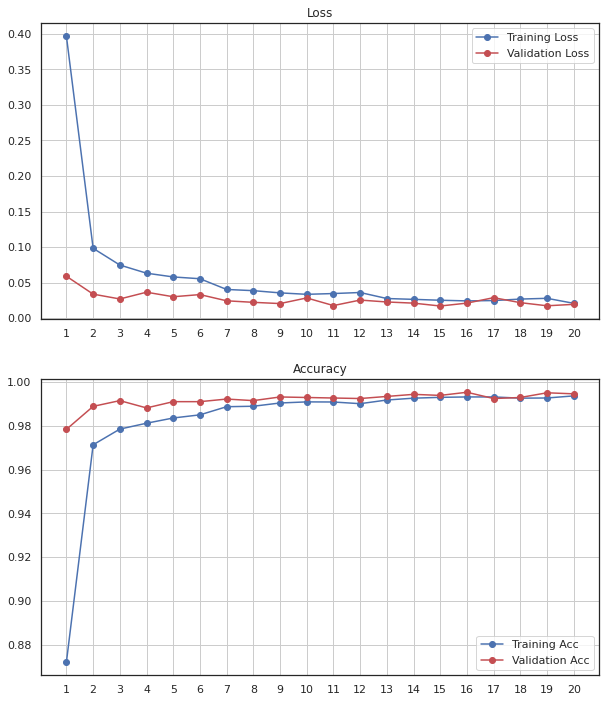

In [27]:
plt.subplots(figsize=(10, 12))

plt.subplot(211)
plt.title("Loss")
loss = history.history["loss"]
plt.plot(range(1, len(loss) + 1), loss, "bo-", label="Training Loss")
loss = history.history["val_loss"]
plt.plot(range(1, len(loss) + 1), loss, "ro-", label="Validation Loss")
plt.xticks(range(1, len(loss) + 1))
plt.grid(True)
plt.legend()

plt.subplot(212)
plt.title("Accuracy")
acc = history.history["acc"]
plt.plot(range(1, len(loss) + 1), acc, "bo-", label="Training Acc")
acc = history.history["val_acc"]
plt.plot(range(1, len(loss) + 1), acc, "ro-", label="Validation Acc")
plt.xticks(range(1, len(loss) + 1))
plt.grid(True)
plt.legend()

In [28]:
pred = model.predict(X_valid)
pred_classes = np.argmax(pred, axis=1)
pred_true = np.argmax(y_valid, axis=1)

### Confusion matrix

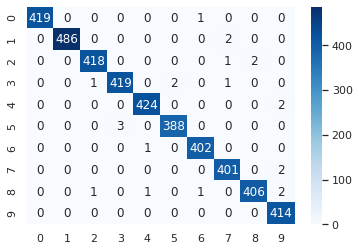

In [29]:
confusion_mtx = confusion_matrix(pred_true, pred_classes)
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap=plt.cm.Blues)

### Results

In [41]:
results = model.predict(test)
results = np.argmax(results, axis=1)

In [42]:
results = pd.concat([pd.Series(range(1, 28001), name="ImageId"),
                     pd.Series(results, name="Label")],
                    axis=1)

In [43]:
results.shape

(28000, 2)

In [44]:
results.to_csv("out.csv", index=False)